# BÁO CÁO BÀI TẬP LỚN
*Bùi Thế Huy - 22022667*

## Tóm tắt
*Chẩn đoán hình ảnh y tế là công cụ quan trọng trong chăm sóc sức khỏe, hỗ trợ chẩn đoán và điều trị thông qua các kỹ thuật không xâm lấn như X-quang, MRI, CT, và siêu âm. Phân đoạn hình ảnh giúp xác định rõ các vùng như cơ quan tổ thương. Các phương pháp thủ công truyền thống thường không hiệu quả. Với sự tiến bộ của trí tuệ nhân tạo và học sâu, các mô hình như U-Net và các biến thể (U-Net++ và U-Net 3+) đã tự động hóa quy trình phân đoạn giúp nâng cao độ chính xác và hiệu quả.*

## Giới thiệu

### Bài toán Image Segmentation

Phân đoạn hình ảnh (“Image Segmentation”) là một nhiệm vụ quan trọng trong xử lý hình ảnh và thị giác máy tính. Nó được sử dụng để chia một hình ảnh thành các vùng tương ứng với các đối tượng, hoặc bối cảnh trong hình ảnh. Trong phân đoạn hình ảnh y tế, việc nhận diện tổn thương trên cơ thể, trên da,nhận diện các cơ quan hoặc khối u là một ứng dụng quan trọng.

Mô hình U-Net là một trong những mô hình hàng đầu cho bài toán này. Nhờ thiết kế được đề cao về khả năng tái tạo chi tiết (“encoder-decoder”), U-Net đã được sử dụng rộng rãi và được hiệu quả cao trong nhiều bài toán segmentation.

### Unet
U-Net là một loại mô hình mang đặc điểm cấu trúc hình “U”.
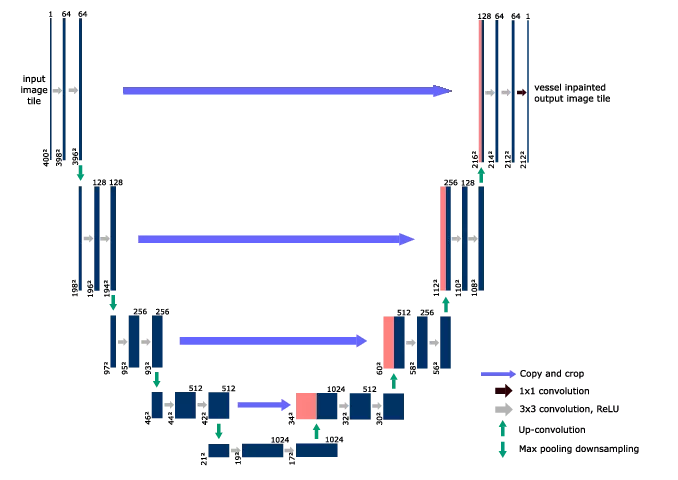

Mô hình bao gồm hai phần chính:

* Encoder: Phần giảm chiều dữ liệu dần dần (“downsampling”) thông qua các lớp convolution và pooling. Quá trình này giúp mô hình học được các đặc trưng quan trọng của hình ảnh.

* Decoder: Phần tăng chiều dữ liệu dần dần (“upsampling”), kết hợp với các đặc trưng từ encoder thông qua các đường nối tắt (skip connections). Những đường nối tắt này giúp bảo tồn các chi tiết bị mất trong quá trình giảm chiều.

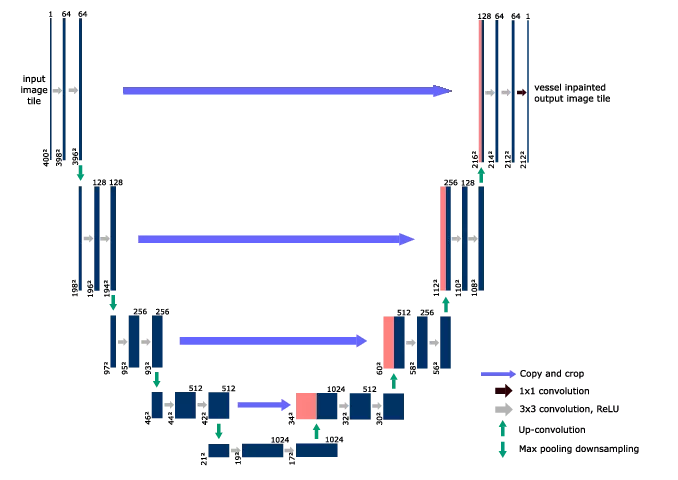

In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from skimage.io import imread
from skimage.transform import resize
from  tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from matplotlib.pyplot import imsave,imshow
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import random
from skimage import transform
from skimage import util

## Dữ liệu

Tập dữ liệu bao gồm hình ảnh y khoa được tổ chức trong hai thư mục chính: Train và Test, với cấu trúc và mục đích sử dụng như sau:

Thư mục Train: Chứa 1.087 hình ảnh và các mặt nạ phân đoạn tương ứng, được sắp xếp thành hai thư mục con:

Image: Gồm 1.087 hình ảnh y khoa đầu vào định dạng .jpg.
Mask: Gồm 1.087 mặt nạ phân đoạn định dạng .png, mỗi mặt nạ tương ứng với một hình ảnh trong thư mục Image.
Người dùng có thể chia tập này thành bộ huấn luyện và bộ kiểm định để phát triển và tinh chỉnh mô hình.
Thư mục Test: Gồm 192 hình ảnh y khoa định dạng .jpg không có mặt nạ phân đoạn.

In [2]:
PATH = '/kaggle/input/k-67-medical-image-segmentation/Dataset/Train'
TEST_PATH = '/kaggle/input/k-67-medical-image-segmentation/Dataset/Test/Image'
OUTPUT_PATH ='/kaggle/working/'

HEIGHT = 128
WIDTH = 128
CHANNELS = 3

## Cài đặt

Trước khi đưa vào huấn luyện, ảnh và mask cần được xử lý, chuẩn bị đầu vào cho mô hình. Đầu tiên cần đọc danh sách các tệp hình ảnh từ thư mục Image và mặt nạ từ thư mục Mask, sau đó kiểm tra sự khớp giữa chúng. Tiếp theo, resize tất cả hình ảnh và mặt nạ về kích thước cố định, chuyển đổi mặt nạ thành dạng nhị phân, và lưu trữ chúng vào các mảng NumPy.

Mục đích của việc này là để chuẩn bị dữ liệu đầu vào đồng nhất và phù hợp cho mô hình, đảm bảo hình ảnh và mặt nạ có cùng kích thước và định dạng, giúp mô hình có thể học và dự đoán chính xác.

In [3]:
def imageProcessingModule():
    raw_files = os.listdir(os.path.join(PATH, 'Image'))
    msk_files = os.listdir(os.path.join(PATH, 'Mask'))
    
    print(f"Number of raw images: {len(raw_files)}")
    print(f"Number of mask images: {len(msk_files)}")


    raw_data = np.zeros((len(raw_files), HEIGHT, WIDTH, CHANNELS), dtype=np.float_)
    mask_data = np.zeros((len(raw_files), HEIGHT, WIDTH, 1), dtype=bool)


    
    index = 0
    for file in raw_files:
        mask_file = file.replace('.jpg', '.png') 
        if (mask_file in msk_files):
            raw_img = imread(os.path.join(PATH, 'Image', file))
            raw_img = resize(raw_img, (HEIGHT, WIDTH), anti_aliasing=True)
            mask = np.zeros((HEIGHT, WIDTH, 1), dtype=bool)
            msk_img = imread(os.path.join(PATH, 'Mask', mask_file))
            msk_img = np.expand_dims(resize(msk_img, (HEIGHT, WIDTH),
                                          anti_aliasing=True), axis=-1)
            mask = np.maximum(mask, msk_img)
            raw_data[index] = raw_img
            mask_data[index] = mask

            if index == 1:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(raw_data[0]) 
                plt.title("Raw Image 0")
                plt.axis('off')
            
                plt.subplot(1, 2, 2)
                plt.imshow(mask_data[0].reshape(HEIGHT, WIDTH), cmap='gray') 
                plt.title("Mask Image 0")
                plt.axis('off')
            
                plt.show() 
            index=index+1
    return raw_data,mask_data

Number of raw images: 1087
Number of mask images: 1087


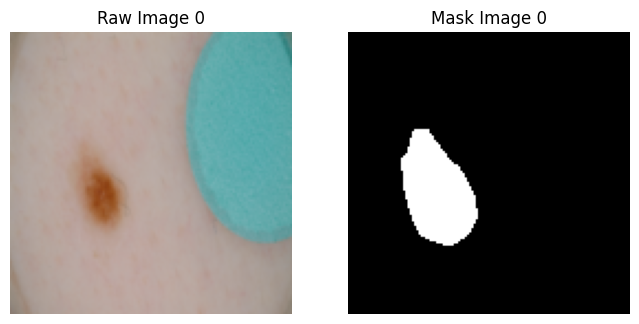

In [4]:
x_data,y_data = imageProcessingModule()
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1)

**Kiểm tra trực quan các ảnh và mask sau khi áp dụng các phép biến đổi dữ liệu**

In [5]:
def augmentedImageChecker(x_train, y_train, seed):
    raw_batch, mask_batch = next(data_generator(x_train, y_train, seed))
    fix, ax = plt.subplots(5,2, figsize=(8,20))
    for i in range(5):
        ax[i,0].set_title('Augmented Train Image')
        ax[i,0].imshow(raw_batch[i,:,:,0])
        ax[i,1].set_title('Augmented Train Mask')
        ax[i,1].imshow(mask_batch[i,:,:,0],cmap='gray')
    plt.show()

In [7]:
def data_generator(x_train, y_train, batch_size):
    data_gen_args = dict(width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10,
            zoom_range = 0.1)
    
    image_generator = ImageDataGenerator(**data_gen_args).flow(x_train, x_train, batch_size, seed = 42)
    mask_generator = ImageDataGenerator(**data_gen_args).flow(y_train, y_train, batch_size, seed = 42)
    while True:
        x_batch, _ = image_generator.__next__()
        y_batch, _ = mask_generator.__next__()

        yield x_batch, y_batch

**Lấy ra một batch dữ liệu từ data generator và hiển thị hình ảnh cùng mặt nạ đã được tăng cường.**

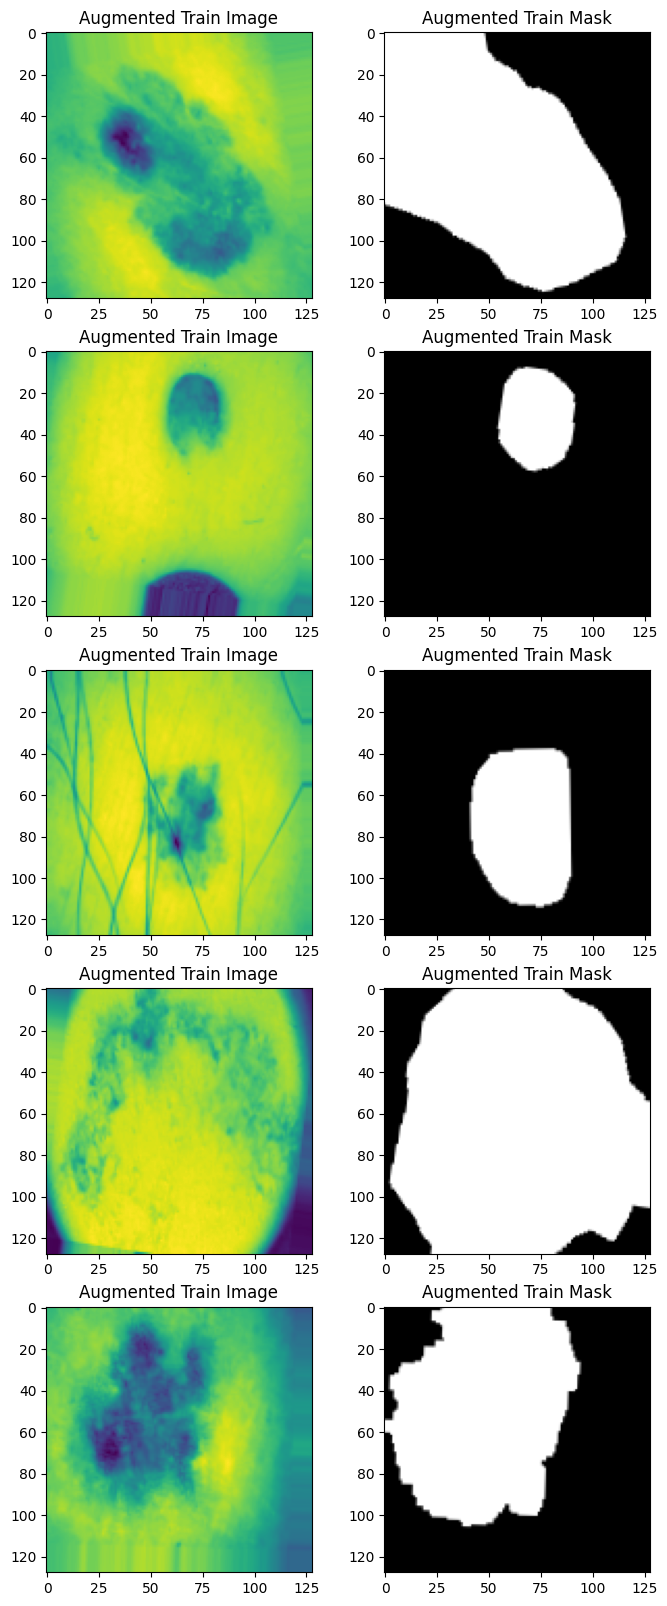

In [8]:
augmentedImageChecker(x_train, y_train, 5)

### Dice coefficient

Dice coefficient được sử dụng phổ biến trong các bài toán phân đoạn hình ảnh, đặc biệt là trong các bài toán phân đoạn y tế . Đây là chỉ số đo lường độ tương đồng giữa hai bộ dữ liệu nhị phân, thường được sử dụng để đánh giá hiệu quả của mô hình phân đoạn. Dice coefficient giúp so sánh sự trùng khớp giữa mặt nạ thực tế (y_true) và mặt nạ dự đoán (y_pred).

Công thức thuật toán:
Công thức của Dice coefficient được tính như sau:

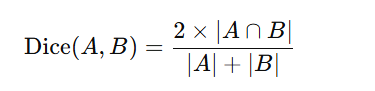

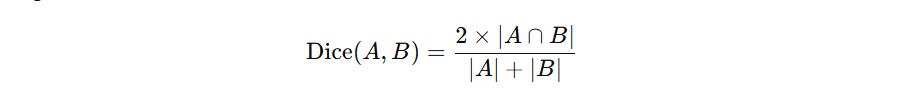

Công thức này trả về giá trị trong khoảng [0, 1], với giá trị 1 nghĩa là hoàn toàn trùng khớp và giá trị 0 nghĩa là không có sự trùng khớp.

In [9]:
import tensorflow as tf
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))


### Unet

U-Net bao gồm các lớp convolution và pooling để trích xuất đặc trưng, kết hợp với các lớp deconvolution và skip connections. Mô hình sử dụng hàm mất mát binary_crossentropy và tối ưu bằng Adam. 

Đánh giá hiệu quả qua dice_coef và accuracy.

Các lớp Conv2D và MaxPooling2D trích xuất đặc trưng từ hình ảnh và giảm kích thước không gian. Lớp Dropout giảm thiểu overfitting bằng cách ngẫu nhiên loại bỏ một số đơn vị trong quá trình huấn luyện.

Các lớp Conv2DTranspose (deconvolution) tái tạo lại chi tiết của hình ảnh, kết hợp với skip connections nhằm giữ lại thông tin quan trọng từ các bước trước.

In [10]:
def modelBuilder(x_train, x_val, y_train, y_val):
    print ('Building U-Net...')
    inputs = tf.keras.layers.Input((HEIGHT, WIDTH, CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(s)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv5)
    upconv6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upconv6 = tf.keras.layers.concatenate([upconv6, conv4])
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv6)

    upconv7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upconv7 = tf.keras.layers.concatenate([upconv7, conv3])
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv7)

    upconv8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upconv8 = tf.keras.layers.concatenate([upconv8, conv2])
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv8)

    upconv9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upconv9 = tf.keras.layers.concatenate([upconv9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])
    model.summary()
    callbacks = [EarlyStopping(patience=6, monitor='val_loss')]
 
    results = model.fit(data_generator(x_train,y_train,8),
                                  steps_per_epoch = 200,
                                  validation_data = (x_val,y_val),
                                  epochs=20,callbacks=callbacks)
 
    model.save('unet.h5')
    return model, results

In [11]:
def plot_model(history):
    print(history.history.keys())
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Building U-Net...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.7772 - dice_coef: 0.5334 - loss: 0.4705 - val_accuracy: 0.8648 - val_dice_coef: 0.7434 - val_loss: 0.3177
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8816 - dice_coef: 0.7255 - loss: 0.2756 - val_accuracy: 0.9030 - val_dice_coef: 0.7822 - val_loss: 0.2561
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8987 - dice_coef: 0.7766 - loss: 0.2363 - val_accuracy: 0.9139 - val_dice_coef: 0.7591 - val_loss: 0.2255
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9118 - dice_coef: 0.7921 - loss: 0.2116 - val_accuracy: 0.8753 - val_dice_coef: 0.7403 - val_loss: 0.3240
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9174 - dice_coef: 0.8227 - loss: 0.1848 - val_accuracy: 0.9009 - val_dice_coef: 0.7929 - val_loss: 0.2515
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9223 - dice_coef: 0.8295 - loss: 0.1718 - val_accuracy: 0.9171 - v

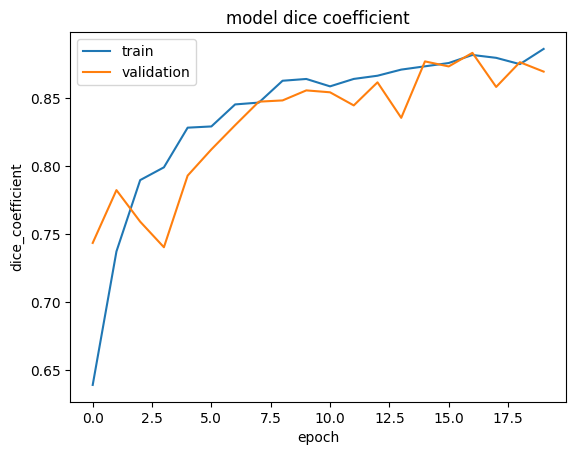

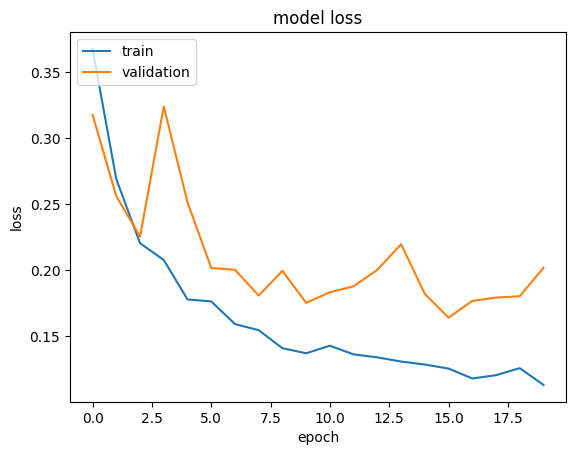

In [12]:
model, history = modelBuilder(x_train, x_val, y_train, y_val)
plot_model(history)

**So sánh giữa mặt nạ thực tế và mặt nạ dự đoán từ mô hình đối với tập dữ liệu kiểm tra (validation).**

In [13]:
def validationImageChecker(xval,yval):
    output_msk = np.zeros((len(xval), HEIGHT, WIDTH), dtype=np.uint8)
    idx = 0
    for im in xval:
        xtest = np.array(im)
        xtest=np.expand_dims(xtest, axis=0)
        pred = model.predict(xtest)
        pred = (pred > 0.55).astype(np.uint8)
        pred = np.squeeze(pred[0])
        output_msk[idx]=pred
        idx+=1
    fix, ax = plt.subplots(5,2, figsize=(8,20))
    for i in range(5):
        ax[i,0].set_title(' Actual Mask')
        ax[i,0].imshow(yval[i,:,:,0])
        ax[i,1].set_title('Predicted Mask')
        ax[i,1].imshow(output_msk[i],cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

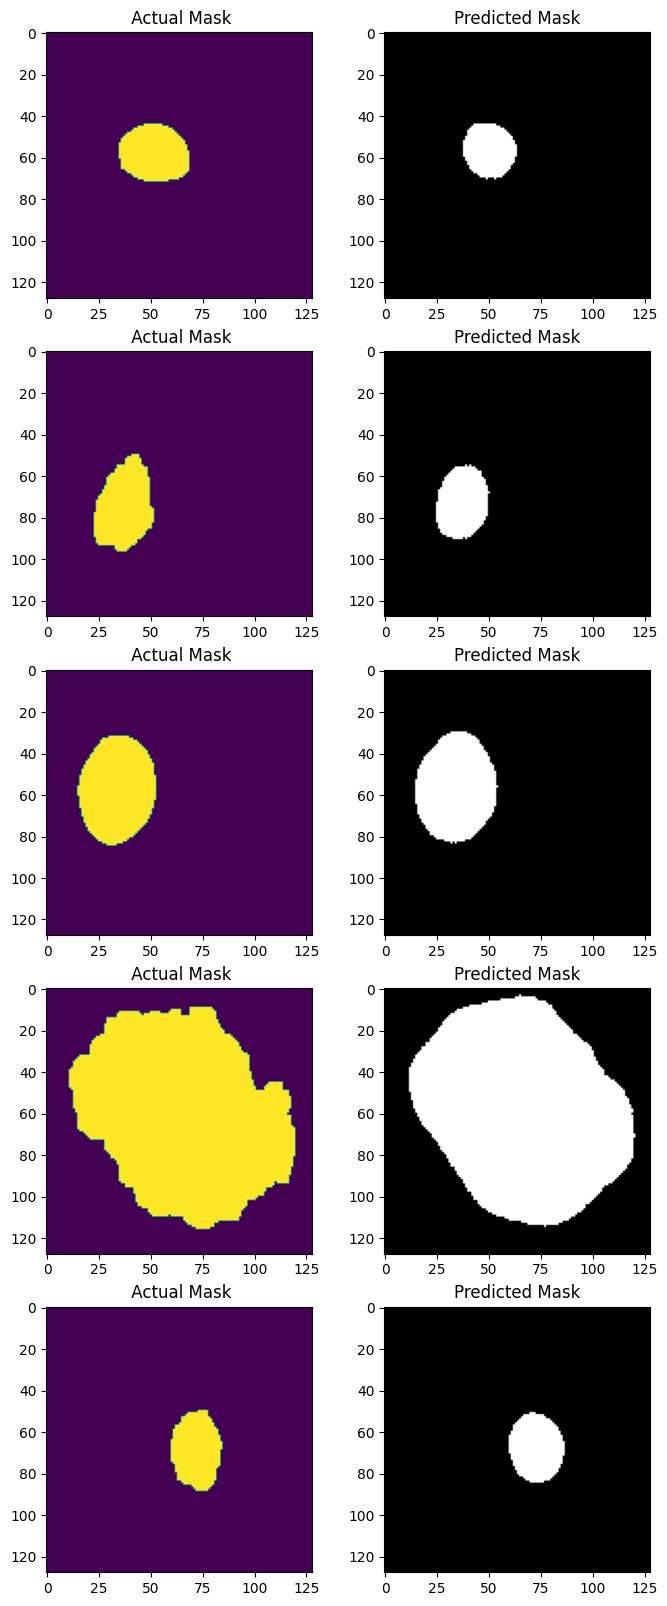

In [93]:
validationImageChecker(x_val,y_val)

### Kiểm tra trên tập test

In [25]:
def test_aa(model, TEST_PATH, HEIGHT, WIDTH, threshold):
    print('Generating mask for test data...')
    test_raw = os.listdir(TEST_PATH)
    
    for idx, file in enumerate(test_raw[:5]):
        test_img = imread(os.path.join(TEST_PATH, file))
        

        org_shpe_array = np.asarray(test_img.shape)
        
        test_img_resized = resize(test_img, (HEIGHT, WIDTH), anti_aliasing=True)
        
        xtest = np.array(test_img_resized)
        xtest = np.expand_dims(xtest, axis=0)
        
        pred = model.predict(xtest)
        pred = (pred > threshold).astype(np.uint8)
        pred = np.squeeze(pred[0])
        
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(test_img_resized)
        plt.title(f"Original Image: {file}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred, cmap='gray')
        plt.title(f"Predicted Mask: {file}")
        plt.axis('off')

        plt.show()



Generating mask for test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


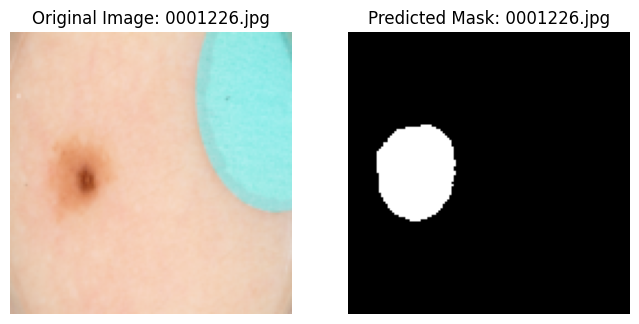

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


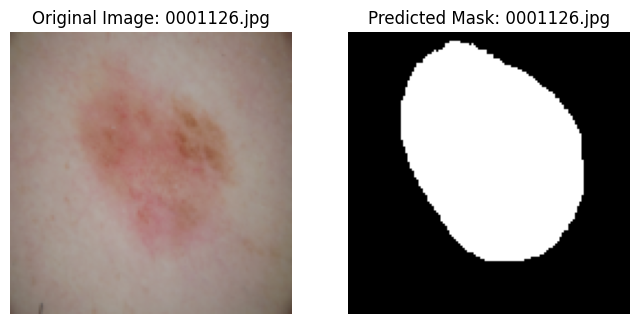

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


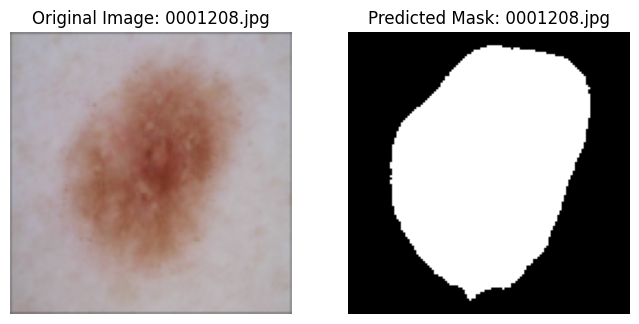

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


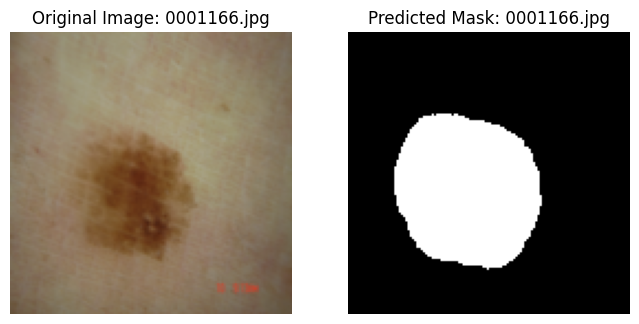

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


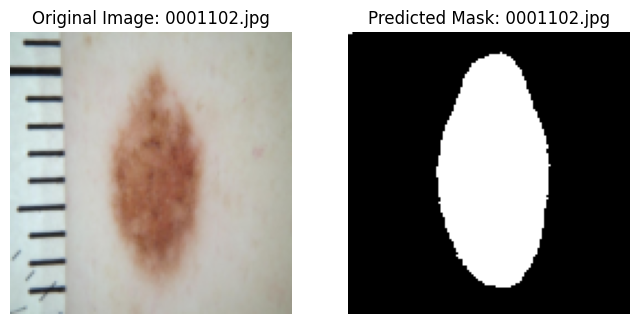

In [29]:
test_aa(model, TEST_PATH, HEIGHT, WIDTH, 0.1)

Generating mask for test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


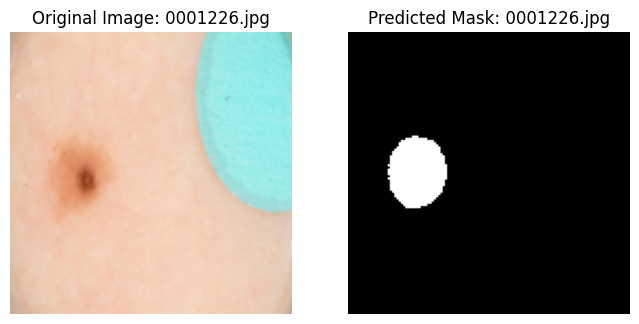

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


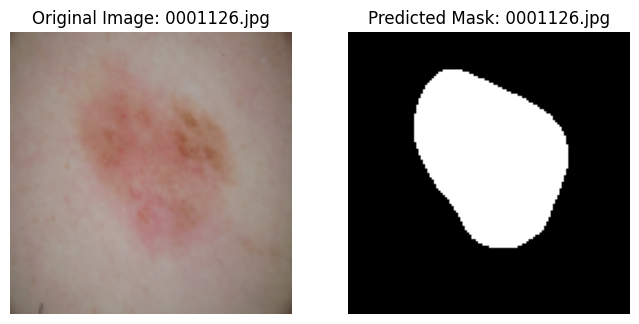

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


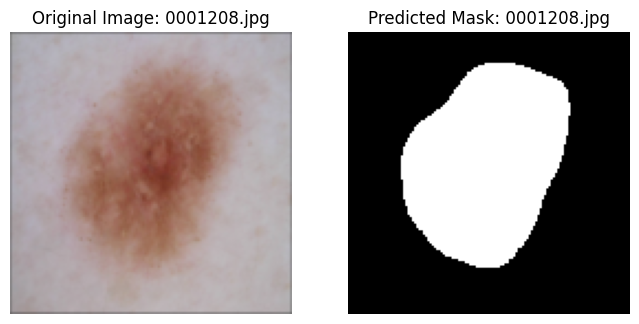

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


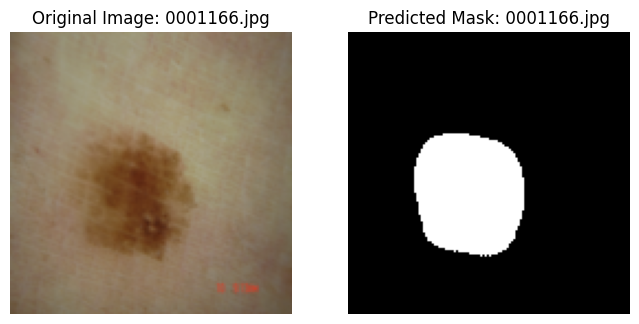

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


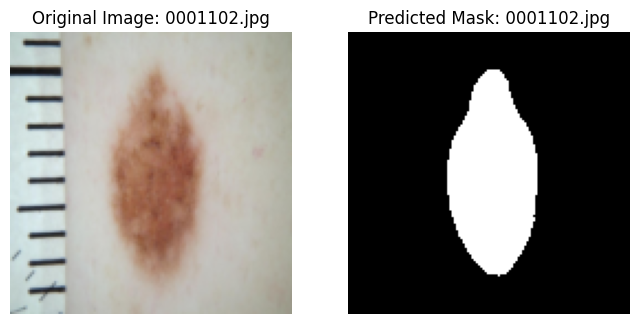

In [30]:
test_aa(model, TEST_PATH, HEIGHT, WIDTH, 0.9)

Generating mask for test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


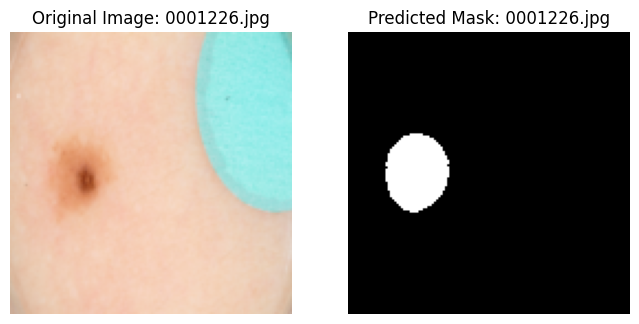

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


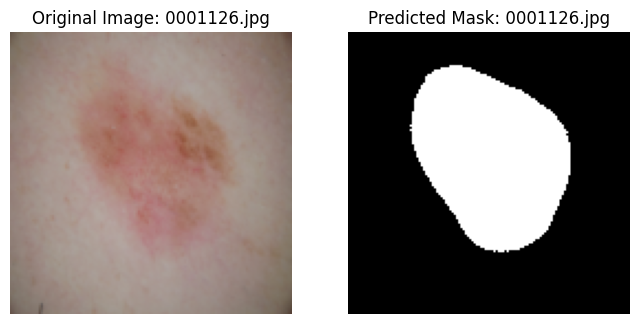

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


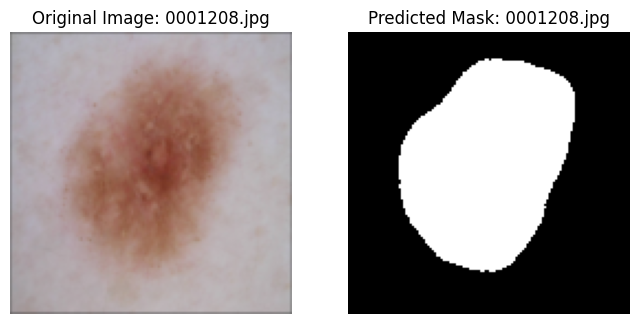

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


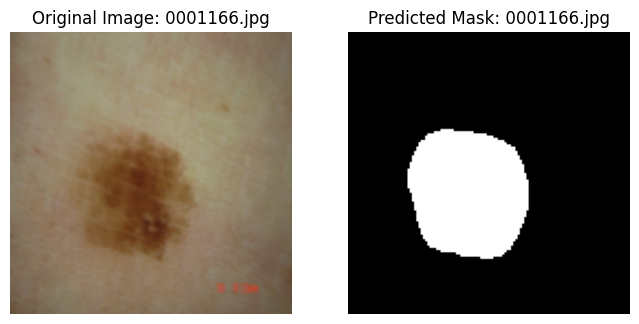

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


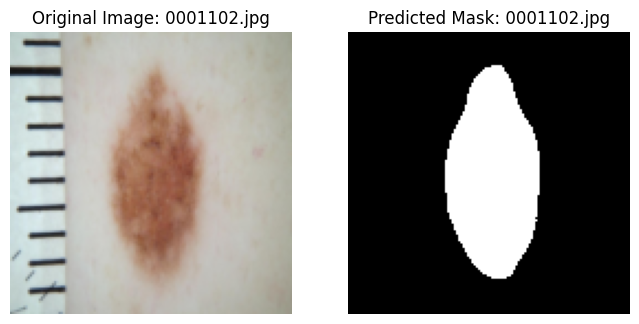

In [32]:
test_aa(model, TEST_PATH, HEIGHT, WIDTH, 0.75)

Co thể thấy rằng threshold = 0.75 cho kết quả tốt hơn.

## Hướng phát triển

Kết quả trên dựa trên những cải tiến nhỏ được thực hiện trên mô hình UNet cơ bản và việc tăng cường dữ liệu. Có thể đạt được kết quả tốt hơn bằng việc:

1. Sử dụng các kiến trúc mạng nơ-ron tiên tiến như Mask RCNN.
2. Sử dụng các phương pháp xử lý ảnh tốt hơn để cải thiện hiệu suất của mô hình.
3. Các phương pháp xử lý ảnh có thể được sử dụng để làm cho dữ liệu sạch hơn. Sử dụng biến dạng đàn hồi để tăng cường dữ liệu.


In [46]:
import os
import numpy as np
import csv
from skimage.io import imread
from skimage.transform import resize

def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

def create_submission_file(model, TEST_PATH, HEIGHT, WIDTH, output_csv='submit.csv'):
    test_raw = os.listdir(TEST_PATH)
    
    submission = []
    
    for idx, file in enumerate(test_raw):
        test_img = imread(os.path.join(TEST_PATH, file))
        

        org_shpe_array = np.asarray(test_img.shape)
        
        test_img_resized = resize(test_img, (HEIGHT, WIDTH), anti_aliasing=True)
        
        xtest = np.array(test_img_resized)
        xtest = np.expand_dims(xtest, axis=0)
        
        pred = model.predict(xtest)
        pred = (pred > threshold).astype(np.uint8)
        pred = np.squeeze(pred[0])
        
        rle = mask_to_rle(pred)
        
        submission.append([file.split('.')[0], rle])
        
    submission.sort(key=lambda x: x[0])
        
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "Mask"])
        writer.writerows(submission)

    print(f"Submission file saved as {output_csv}")

create_submission_file(model, TEST_PATH, HEIGHT, WIDTH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━